In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import gan_helper
import sklearn.model_selection
import torch
import models
import util
import config
import viz
import os
import scipy.stats
GAN = gan_helper.Generator() # initializes gan
print('Done!')

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Done!


In [50]:
z = np.random.randn(2000, 512)
w = GAN.z_to_style(z)

In [ ]:
plt.figure(dpi=300)
for i in range(512):
    plt.hist(w[:, 0, i], alpha=0.1)
plt.xlabel('latent value')
plt.show()

Text(0.5, 0, 'latent value')

In [ ]:
im1 = GAN.gen(z[0])
im2 = GAN.gen_full(w[0:1])
im3 = GAN.gen_full_old(w[0:1])

**note - look at some of the plots in `analyze_inn` nb to help with this**

# load latent-mapping model

In [1]:
orth_dict = pkl.load(open(oj(config.PROCESSED_DIR, '02_orth.pkl'), 'rb'))
orth_mat = orth_dict['vecs_orth'].transpose() # make it (512, 6)
offsets = np.array([a[0] for a in orth_dict['intercepts']]).flatten()

def predict(z, orth_mat, offsets):
    '''Return projection onto attribute space
    z is (batch_size, 512)
    '''
    return z @ orth_mat + offsets

def increase(z, orth_mat, attr_index, mult):
    '''Move in direction that increases attribute a
    '''
    z_alt = z + mult * orth_mat[:, attr_index].flatten()     
    print(np.around(z_alt @ orth_mat + offsets, 2))
    return z_alt


def even_bounds(z, attr_index, bounds=(-1, 1)):
    '''Generate z which varies
    '''

def normalize(u):
    return u / np.linalg.norm(u)

def project_to_plane(X, w, b):
    w, b = w.copy(), b.copy()

    # Get and normalize coefficients
    b = b / np.linalg.norm(w)
    w = normalize(w)

    # Project points back to hyperplane, decision value = 0
    d = np.sum(w * X, -1) + b

    return X - w * np.expand_dims(d, 1)
    
# project the image to boundary
z0 = np.random.randn(1, 512)

# z_new = project_to_boundary(z0, orth_mat, offsets, attr_index=0)
z_new = project_to_plane(z0, orth_mat[:, attr_index], offsets[attr_index])

NameError: name 'pkl' is not defined

**let's walk in face space (using shared z)**

In [2]:
# # min/max to vary these attributes
# attr_bounds = { 
#     'age': (-2, 2),
#     'facial-hair': (-2, 2),
#     'skin-color': (-2, 2),
#     'gender': (-1, 1),
#     'hair-length': (-2, 2),
#     'makeup': (-2, 2)
# }
# min/max to vary these attributes
attr_mults = { 
    'age': 2,
    'facial-hair': 2,
    'skin-color': 3,
    'gender': 2,
    'hair-length': 5,
    'makeup': 0.1
}

# z0 = np.zeros((1, 512)) #X[1:2] * 0
np.random.seed(1)
# z0 = np.random.randn(1, 512) * 0.1
z0 = z_new
N_IMS = 7 # should be odd

for attr_index, attr in enumerate(config.ATTRS):
    zs = np.zeros((N_IMS, 512))
    mult = 1 * attr_mults[attr] # 1e0 #5e-4
    for j in range(N_IMS):
        diff = j - N_IMS // 2
        zs[j] = increase(z0, orth_mat, attr_index=attr_index, mult=diff * mult)
    images = GAN.gen(np.vstack(zs))
    util.plot_row(images, suptitle=attr)
    plt.show()

NameError: name 'np' is not defined

# using projected images (full z)

**get a latent from embedding**

In [78]:
fnames = sorted([fname 
          for fname in os.listdir(config.REAL_LATENT_ENCODINGS_DIR)
          if '.npy' in fname])
latents = np.load(oj(config.REAL_LATENT_ENCODINGS_DIR, fnames[1]))
z0 = np.expand_dims(latents, 0)

In [ ]:
# print('z at different scales are not the same')
# viz.corrplot(np.corrcoef(latents))
# plt.colorbar()
# plt.show()

In [ ]:
# im = GAN.gen_full(z0)
# util.imshow(im)

**let's walk in face space**

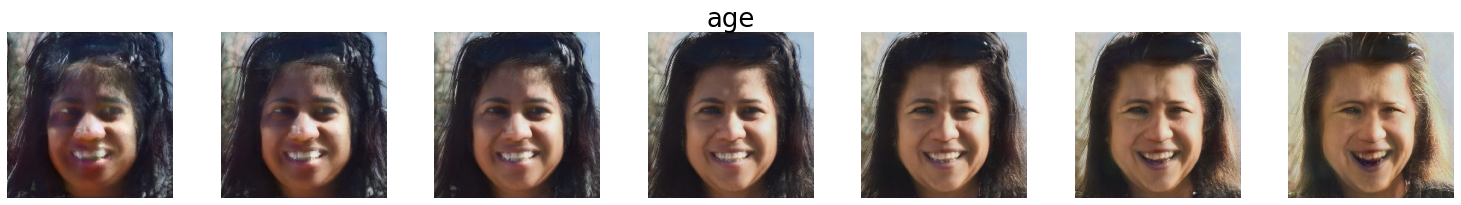

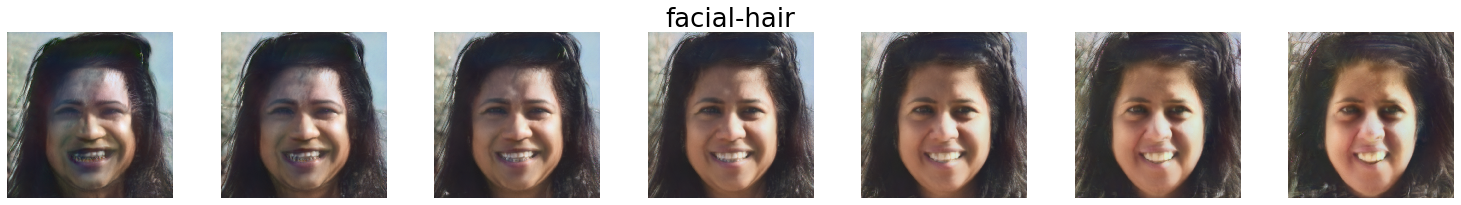

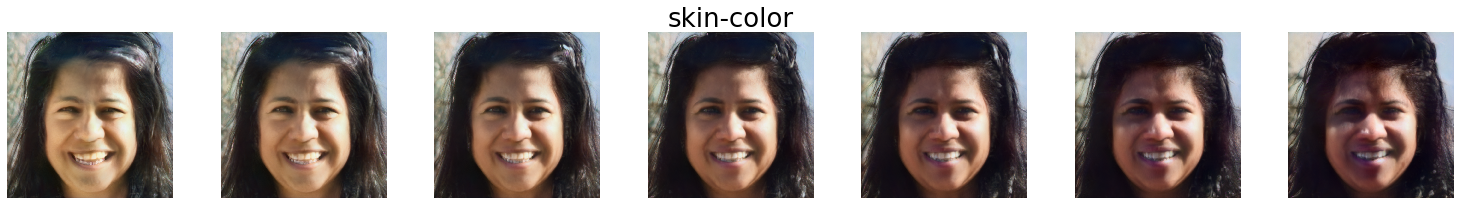

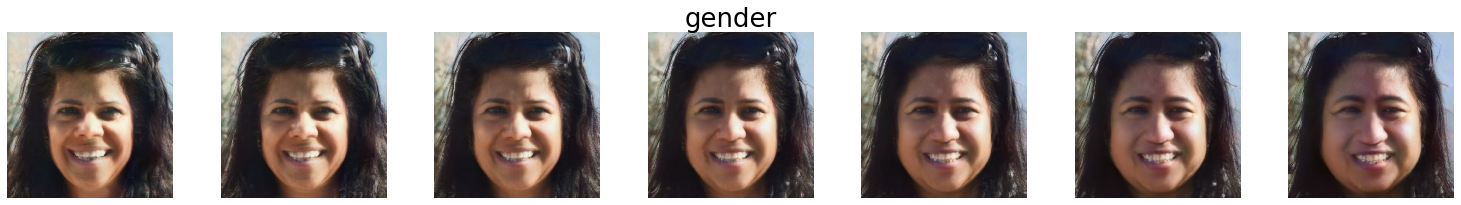

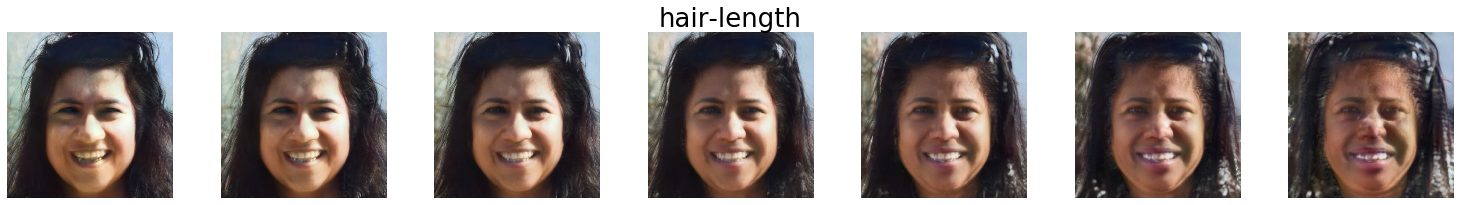

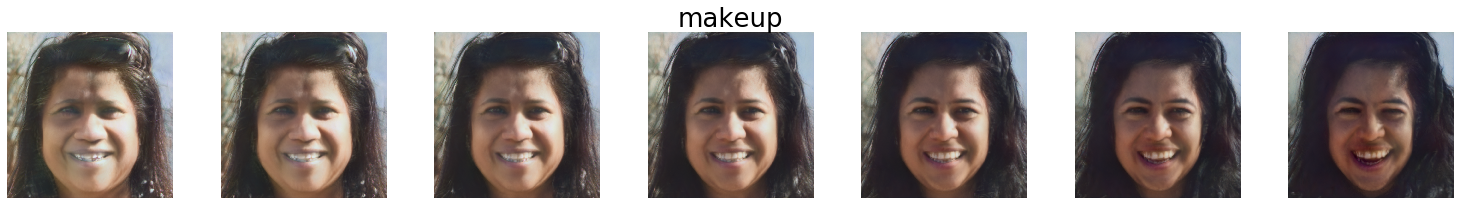

In [88]:
z0 = np.squeeze(z0)
# z0: (18, 512)
N_IMS = 7 # should be odd
MULT = 18
a = m(torch.Tensor(z0))
for attr_index, attr in enumerate(config.ATTRS):
    
    # get a mapping for z0
    a_arr = a.repeat((N_IMS, 1))
    delta = attr_deltas[attr]
    mult = 0.05
#     (bound_min, bound_max) = attr_bounds[attr]
    for j in range(N_IMS):
        diff = j - N_IMS // 2
#         a_arr[j * MULT: j * MULT + 17, attr_index] += diff * mult * delta
        a_arr[j * MULT: (j + 1) * MULT, attr_index] += diff * mult * delta
    zs = util.detach(m(a_arr, rev=True))
    zs = zs.reshape(N_IMS, MULT, -1).squeeze()
    images = GAN.gen_full(zs)
    util.plot_row(images, suptitle=attr)
    plt.show()